# 0.a. Import and settings

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc
from scanpy.plotting._tools.scatterplots import plot_scatter
import scanpy_scripts as ss
import bbknn

expr_cmap = ss.lib.expression_colormap(background_level=0.01)
doublet_cmap = ss.lib.expression_colormap(0.2)
np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
sc.settings.figdir = 'png'

In [3]:
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# 0.b. Define functions

In [5]:
def diffexp(
    adata, basis='umap', key=None, res=None, method='logreg',
    filter_params={'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 2},
    extra_genes=None, **kwargs
):
    if key:
        grp_key = f'{key}_r{str(res).replace(".", "_")}'
        basis=f'{basis}_{key}'
    else:
        grp_key = f'r{str(res).replace(".", "_")}'
    de_tbl = ss.lib.diffexp(
        adata, key_added=grp_key, groupby=f'leiden_{grp_key}', method=method,
        filter_params=filter_params, **kwargs,
    )
    de_genes = list(de_tbl.groupby('cluster').head(4)['genes'].values)
    if extra_genes:
        de_genes.extend(extra_genes)
    rcParams.update({'figure.figsize': (4,4)})
    sc.pl.rank_genes_groups(adata, key=f'rank_genes_groups_{grp_key}', show=False)

    sc.pl.dotplot(
        adata,
        var_names=de_genes,
        groupby=f'leiden_{grp_key}',
        #standard_scale='var',
        show=False
    )

    rcParams.update({'figure.figsize':(2.5,2.5)})
    plot_scatter(
        adata, basis=basis, color_map=expr_cmap, use_raw=True, ncols=8, size=10, color=de_genes, show=False)
    rcParams.update({'figure.figsize':(3,3)})
    ss.lib.plot_embedding(adata, basis=basis, groupby=f'leiden_{grp_key}', size=20, show=False)
    return de_tbl

In [6]:
def update_diffexp(
    ad, basis='umap', key=None, res=None,
    filter_params={'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 2},
    extra_genes=None,
):
    if key:
        grp_key = f'{key}_r{str(res).replace(".", "_")}'
        basis=f'{basis}_{key}'
    else:
        grp_key = f'r{str(res).replace(".", "_")}'
    de_key = f'rank_genes_groups_{grp_key}'
    if filter_params:
        sc.tl.filter_rank_genes_groups(
            ad,
            key=de_key,
            key_added=de_key + '_filtered',
            use_raw=True,
            **filter_params,
        )
    de_tbl = ss.lib.extract_de_table(ad.uns[de_key + '_filtered'])
    de_tbl = de_tbl.loc[de_tbl.genes.astype(str) != 'nan', :]

    de_genes = list(de_tbl.groupby('cluster').head(4)['genes'].values)
    if extra_genes:
        de_genes.extend(extra_genes)
    rcParams.update({'figure.figsize': (4,4)})
    sc.pl.rank_genes_groups(ad, key=f'rank_genes_groups_{grp_key}', show=False)

    sc.pl.dotplot(
        ad,
        var_names=de_genes,
        groupby=f'leiden_{grp_key}',
        #standard_scale='var',
        show=False
    )

    rcParams.update({'figure.figsize':(2.5,2.5)})
    plot_scatter(
        ad, basis=basis, color_map=expr_cmap, use_raw=True, ncols=8, size=10, color=de_genes, show=False)
    rcParams.update({'figure.figsize':(3,3)})
    ss.lib.plot_embedding(ad, basis=basis, groupby=f'leiden_{grp_key}', size=20, show=False)
    return de_tbl

In [4]:
def hex2rgba(hex_colors):
    return [tuple(int(h[i:i+2], 16)/255.0 for i in (1, 3, 5)) for h in hex_colors]

In [5]:
def check_doublets(
    ad, groupby, basis=None, p='bh_doublet_pval', score='scrublet_score', label='doublet', initial_pmin=0.05,
    upper_mad_only=(True, True), **kwargs
):
    if groupby not in ad.obs.columns:
        raise KeyError(f'{groupby} not found in `.obs`')
    ad.obs[label] = ad.obs[p] < initial_pmin
    doublet_freqs = ad.obs.groupby(groupby)[label].agg(lambda x: sum(x)/len(x))
    z_freq, p_freq, p_freq_adj = ss.lib.test_outlier(doublet_freqs, upper_mad_only=upper_mad_only)
    doublet_scores = ad.obs.groupby(groupby)[score].agg(lambda x: sum(x)/len(x))
    z_score, p_score, p_score_adj = ss.lib.test_outlier(doublet_scores, upper_mad_only=upper_mad_only)

    thresholds = {'min_score': max(doublet_scores)/2, 'min_freq': max(doublet_freqs)/2, 'max_p_score': 0.05, 'max_p_freq': 0.05}
    for k in thresholds:
        if k in kwargs:
            thresholds[k] = kwargs[k]
            del kwargs[k]

    if basis and f'X_{basis}' in ad.obsm.keys():
        ss.lib.set_figsize((3.5, 3.5))
        plot_scatter(ad, basis=basis, color=[score, label, groupby], color_map=doublet_cmap, legend_loc='on data', legend_fontsize=8, **kwargs)

    ss.lib.set_figsize((7,3))
    sc.pl.violin(ad, keys=[p, score], groupby=groupby)
    colors = hex2rgba(ad.uns[f'{groupby}_colors'])
    df = pd.DataFrame({'score': doublet_scores, 'p_score': p_score, 'freq': doublet_freqs, 'p_freq': p_freq})
    fig, ax = plt.subplots(ncols=2)
    df.plot(kind='scatter', x='p_score', y='p_freq', c=colors, ax=ax[0])
    ax[0].set_xlim((-0.02, 0.5))
    ax[0].set_ylim((-0.02, 0.5))
    ax[0].hlines(thresholds['max_p_freq'], xmin=0, xmax=1, linestyle='--', linewidth=1)
    ax[0].vlines(thresholds['max_p_score'], ymin=0, ymax=1, linestyle='--', linewidth=1)
    df.plot(kind='scatter', x='score', y='freq', c=colors, ax=ax[1])
#     ax[1].set_xlim((-1, 10))
    ax[1].set_ylim((-0.02, 0.5))
    ax[1].hlines(thresholds['min_freq'], xmin=min(doublet_scores), xmax=max(doublet_scores), linestyle='--', linewidth=1)
    ax[1].vlines(thresholds['min_score'], ymin=0, ymax=1, linestyle='--', linewidth=1)
    for i in range(len(p_freq)):
        ax[0].annotate(i, xy=(df.p_score[i], df.p_freq[i]))
        ax[1].annotate(i, xy=(df.score[i], df.freq[i]))
    ss.lib.set_figsize((3.5, 3.5))
    return df

# 1. Load data

In [77]:
CATEGORY_NAME = 'melanocytes'
CATEGORY_CLUSTER_ID = 7
MIN_BATCH_SIZE = 10
DE_METHOD = 't-test_overestim_var'
DE_FILTERS = {'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 1.5}
KNOWN_MARKERS = ['PMEL']
CLUSTER_RESOLUTIONS = [0.1, 0.2, 0.3, 0.4, 0.5]

In [7]:
fetal_ad = sc.read('data/h5ad/fetal_skin_raw.h5ad', mode='r')

In [8]:
fetal_ad.obs.head()

bh_doublet_pval cell_caller  \
index                                                             
AAACCTGCACTCTGTC-1-4834STDY7002879         0.907861        Empt   
AAACCTGGTCAGTGGA-1-4834STDY7002879         0.907861        Both   
AAAGATGGTCGATTGT-1-4834STDY7002879         0.907861        Both   
AAAGCAAAGATGTGGC-1-4834STDY7002879         0.882352        Both   
AAAGCAACAAGCCGTC-1-4834STDY7002879         0.907861        Empt   

                                    cluster_scrublet_score  doublet_pval  \
index                                                                      
AAACCTGCACTCTGTC-1-4834STDY7002879                0.164557      0.455284   
AAACCTGGTCAGTGGA-1-4834STDY7002879                0.157082      0.500000   
AAAGATGGTCGATTGT-1-4834STDY7002879                0.157082      0.500000   
AAAGCAAAGATGTGGC-1-4834STDY7002879                0.225806      0.150885   
AAAGCAACAAGCCGTC-1-4834STDY7002879                0.164557      0.455284   

                                     mt_prop  n_counts  n_genes  \
index                                                             
AAACCTGCACTCTGTC-1-4834STDY7002879  0.202597     385.0      239   
AAACCTGGTCAGTGGA-1-4834STDY7002879  0.062532    5917.0     1776   
AAAGATGGTCGATTGT-1-4834STDY7002879  0.030894   10261.0     2750   
AAAGCAAAGATGTGGC-1-4834STDY7002879  0.012647    7749.0     2308   
AAAGCAACAAGCCGTC-1-4834STDY7002879  0.197686    1037.0      606   

                                          sanger_id  scrublet_score chemistry  \
index                                                                           
AAACCTGCACTCTGTC-1-4834STDY7002879  4834STDY7002879        0.105590    SC3Pv2   
AAACCTGGTCAGTGGA-1-4834STDY7002879  4834STDY7002879        0.225806    SC3Pv2   
AAAGATGGTCGATTGT-1-4834STDY7002879  4834STDY7002879        0.149606    SC3Pv2   
AAAGCAAAGATGTGGC-1-4834STDY7002879  4834STDY7002879        0.201970    SC3Pv2   
AAAGCAACAAGCCGTC-1-4834STDY7002879  4834STDY7002879        0.225806    SC3Pv2   

                                   donor gender  pcw sorting           sample  \
index                                                                           
AAACCTGCACTCTGTC-1-4834STDY7002879   F16   male    8   CD45P  F16_male_8+1PCW   
AAACCTGGTCAGTGGA-1-4834STDY7002879   F16   male    8   CD45P  F16_male_8+1PCW   
AAAGATGGTCGATTGT-1-4834STDY7002879   F16   male    8   CD45P  F16_male_8+1PCW   
AAAGCAAAGATGTGGC-1-4834STDY7002879   F16   male    8   CD45P  F16_male_8+1PCW   
AAAGCAACAAGCCGTC-1-4834STDY7002879   F16   male    8   CD45P  F16_male_8+1PCW   

                                   chemistry_sorting  
index                                                 
AAACCTGCACTCTGTC-1-4834STDY7002879      SC3Pv2_CD45P  
AAACCTGGTCAGTGGA-1-4834STDY7002879      SC3Pv2_CD45P  
AAAGATGGTCGATTGT-1-4834STDY7002879      SC3Pv2_CD45P  
AAAGCAAAGATGTGGC-1-4834STDY7002879      SC3Pv2_CD45P  
AAAGCAACAAGCCGTC-1-4834STDY7002879      SC3Pv2_CD45P

In [9]:
spleen_samples = ['F69-GEX_1_SPL_45P', 'F69-GEX_2_SPL_45N', 'F69-GEX_3_SPL_45N']

In [10]:
fetal_ad = fetal_ad[~fetal_ad.obs['sample'].isin(spleen_samples), :]

In [11]:
fetal_ad

View of AnnData object with n_obs × n_vars = 235201 × 33694 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting'
    var: 'gene_ids'

In [12]:
g1_s = pd.read_csv('data/misc/G1-S_genes.list', header=None, names=['gene'])
g2_m = pd.read_csv('data/misc/G2-M_genes.list', header=None, names=['gene'])
jp_cc = pd.read_csv('data/misc/JP_cycle_genes.list', header=None, names=['gene'])

In [13]:
cc_genes = list(pd.concat([g1_s, g2_m, jp_cc]).gene.values)

In [14]:
fetal_ad.var['cc'] = fetal_ad.var_names.isin(cc_genes)

In [15]:
annot = pd.read_csv('fetal_annotation_rachel-201904.txt', sep='\t', header=None, names=['index', 'annot'], index_col=0)

In [16]:
fetal_ad.obs['annot'] = fetal_ad.obs.merge(annot, how='left', left_index=True, right_index=True)['annot']

In [17]:
fetal_ad.obs['doublet'] = fetal_ad.obs['bh_doublet_pval'] < 0.1

In [18]:
hierarchy1 = pd.read_csv('hierarchy1.txt', sep='\t', index_col=0)

In [19]:
fetal_ad.obs = fetal_ad.obs.merge(hierarchy1, how='left', left_index=True, right_index=True)

In [20]:
ad = fetal_ad[(fetal_ad.obs['hierarchy1'] == 7), :]

In [21]:
ad.obs['sample'].value_counts()

F71-GEX_5_SKI_45en    135
F69-GEX_7_SKI_45en    116
F50_SK_CD45N_1         81
F50_SK_CD45N_2         72
F34_female_8+1PCW      66
F51_SK_CD45N_1         64
F51_SK_CD45N_2         61
F69-GEX_5_SKI_45N      51
F71-GEX_4_SKI_45N      50
F32_female_7+6PCW      47
F71-GEX_3_SKI_45N      46
F69-GEX_6_SKI_45N      45
F33_female_9+5PCW      34
F38_male_12PCW         31
F41_female_16PCW       22
F61_SK_CD45N_1         19
F45_female_13+6PCW     16
F61_SK_CD45N_2         14
F35_female_7+6PCW      13
F51_SK_CD45P_6          8
F50_SK_CD45P_6          7
F19_female_10+2PCW      6
F17_male_9+1PCW         5
F50_SK_CD45P_5          5
F51_SK_CD45P_5          4
F69-GEX_4_SKI_45P       2
F71-GEX_1_SKI_45P       2
F71-GEX_2_SKI_45P       1
Name: sample, dtype: int64

In [22]:
sample_sizes = ad.obs['sample'].value_counts()

In [23]:
valid_batches = sample_sizes[sample_sizes >= 10].index.to_list()

In [24]:
ad = ad[ad.obs['sample'].isin(valid_batches), :]

In [25]:
ad

View of AnnData object with n_obs × n_vars = 983 × 33694 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'doublet', 'hierarchy1'
    var: 'gene_ids', 'cc'

In [27]:
ad.write('data/h5ad/fetal_skin_hierarch1_melanocytes.h5ad', compression='gzip')

# 2. QC

In [28]:
ad = sc.read('data/h5ad/fetal_skin_hierarch1_melanocytes.h5ad')

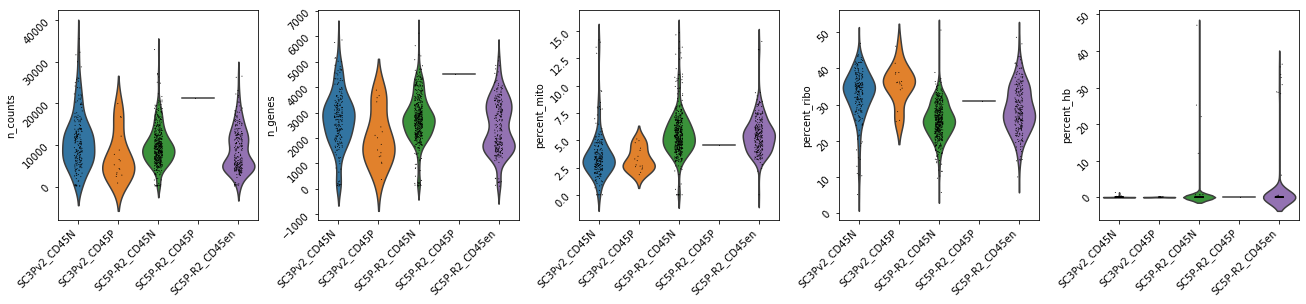

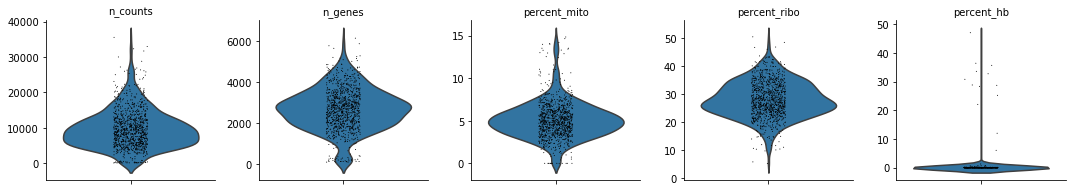

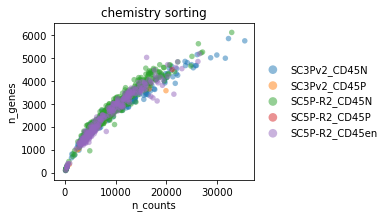

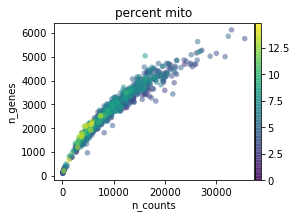

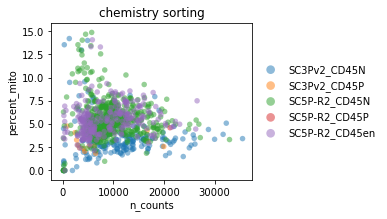

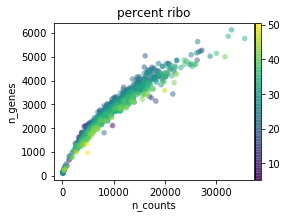

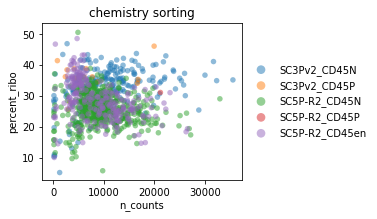

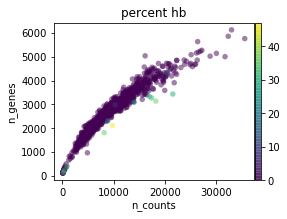

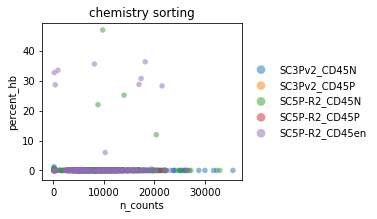

AnnData object with n_obs × n_vars = 983 × 33694 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'doublet', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells'
    uns: 'chemistry_sorting_colors'

In [29]:
rcParams.update({'figure.figsize': (4,4)})
ss.lib.simple_default_pipeline(ad, qc_only=True, batch='chemistry_sorting')

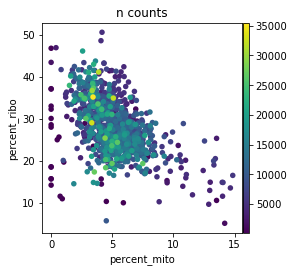

In [30]:
rcParams.update({'figure.figsize': (4,4)})
sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='n_counts')

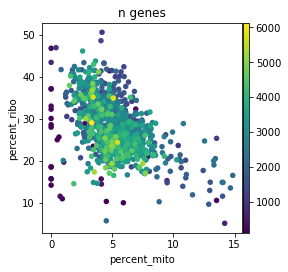

In [31]:
sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='n_genes')

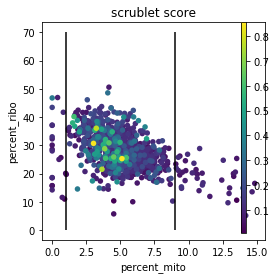

In [35]:
fig, ax = plt.subplots()
sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='scrublet_score', ax=ax, show=False)
ax.vlines(x=[1, 9.0], ymin=0, ymax=70)

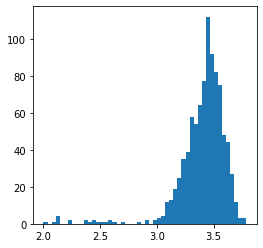

In [36]:
_ = plt.hist(np.log10(ad.obs.loc[(ad.obs.percent_mito>0.5)&(ad.obs.percent_mito<=9),'n_genes']), bins=50)

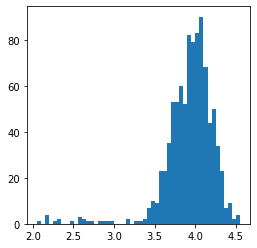

In [37]:
_ = plt.hist(np.log10(ad.obs.loc[(ad.obs.percent_mito>0.5)&(ad.obs.percent_mito<=9),'n_counts']), bins=50)

# 3. Default preprocessing

In [38]:
ad = ad[
    (ad.obs.percent_mito>=1) &
    (ad.obs.percent_mito<9) &
    (ad.obs.n_genes>=1000) &
    (ad.obs.n_counts>=2000) &
    (ad.obs.percent_hb<2.5), :]
ad = ad[:, (ad.var.n_cells>=3)]

In [40]:
ad

View of AnnData object with n_obs × n_vars = 890 × 15370 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'doublet', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells'

In [41]:
ad1 = ad.copy()[:, ~(ad.var.mito | ad.var.hb | ad.var.ribo)]
ad2 = ad.copy()[:,~(ad.var.mito | ad.var.hb | ad.var.ribo | ad.var.cc)]

In [42]:
ss.lib.simple_default_pipeline(
    ad1,
    filter_params=None,
    hvg_params={'flavor': 'seurat', 'by_batch': ['chemistry', 2]},
    scale_params={'max_value': 10},
    pca_params={'n_comps': 50, 'svd_solver': 'arpack', 'use_highly_variable': True},
    harmony_params=None,
    nb_params={'use_rep': 'X_pca', 'key_added': 'orig'},
    umap_params={'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    leiden_params={'resolution': [0.1, 0.2, 0.3, 0.4], 'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

AnnData object with n_obs × n_vars = 890 × 15250 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'doublet', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'neighbors', 'leiden'
    obsm: 'X_pca', 'X_umap_orig'
    varm: 'PCs'

In [43]:
ss.lib.simple_default_pipeline(
    ad2,
    filter_params=None,
    hvg_params={'flavor': 'seurat', 'by_batch': ['chemistry', 2]},
    scale_params={'max_value': 10},
    pca_params={'n_comps': 50, 'svd_solver': 'arpack', 'use_highly_variable': True},
    harmony_params=None,
    nb_params={'use_rep': 'X_pca', 'key_added': 'orig'},
    umap_params={'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    leiden_params={'resolution': [0.1, 0.2, 0.3, 0.4], 'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

AnnData object with n_obs × n_vars = 890 × 14691 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'doublet', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'neighbors', 'leiden'
    obsm: 'X_pca', 'X_umap_orig'
    varm: 'PCs'

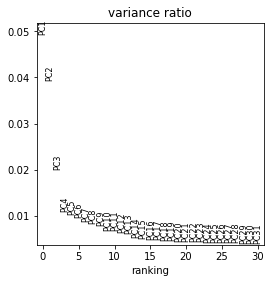

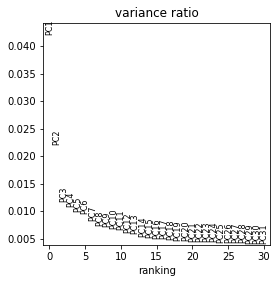

In [44]:
rcParams.update({'figure.figsize': (4,4)})
sc.pl.pca_variance_ratio(ad1, n_pcs=30)
sc.pl.pca_variance_ratio(ad2, n_pcs=30)

In [45]:
k_annot = (ad1.obs['annot'] != 'nan').values
ad1.obs['lr_annot'] = ss.lib.LR_annotate(ad1, train_label=ad1.obs['annot'].values, train_x=ad1.obsm['X_pca'],
                                        subset=k_annot, use_rep='X_pca', return_label=True)
ad1.obs['lr_annot'] = ad1.obs['lr_annot'].astype('category')

In [46]:
k_annot = (ad2.obs['annot'] != 'nan').values
ad2.obs['lr_annot'] = ss.lib.LR_annotate(ad2, train_label=ad2.obs['annot'].values, train_x=ad2.obsm['X_pca'],
                                        subset=k_annot, use_rep='X_pca', return_label=True)
ad2.obs['lr_annot'] = ad2.obs['lr_annot'].astype('category')

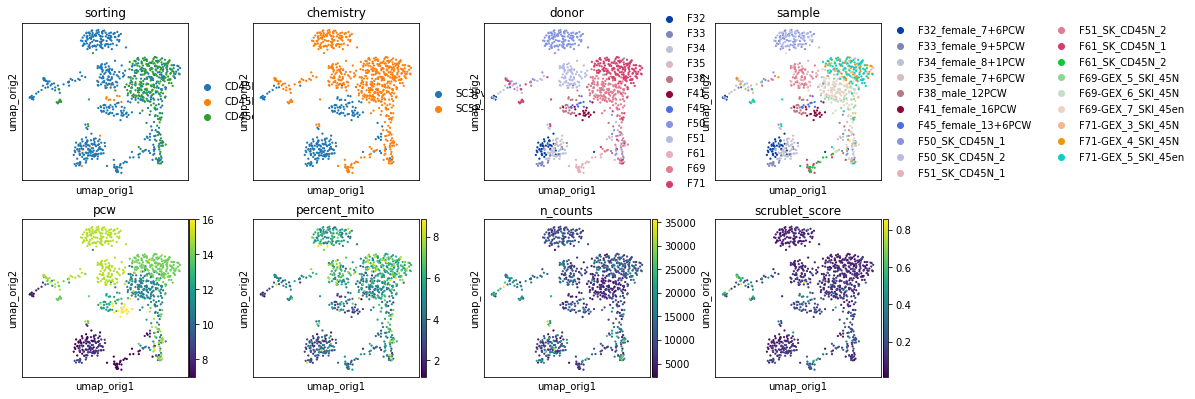

In [47]:
rcParams.update({'figure.figsize':(3,3)})
plot_scatter(ad1, basis='umap_orig',
             color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'], size=20)

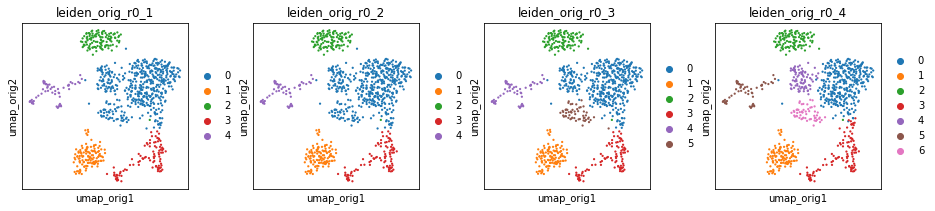

In [48]:
plot_scatter(ad1, basis='umap_orig', color_map=expr_cmap,
             color=[f'leiden_orig_r{str(res).replace(".", "_")}' for res in [0.1, 0.2, 0.3, 0.4]], size=20, ncols=4)

In [50]:
doublet_freq = ad1.obs.groupby('leiden_orig_r0_1')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=True)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

                      freq    p
leiden_orig_r0_1               
0                 0.012072  0.5
1                 0.000000  0.5
2                 0.000000  0.5
3                 0.000000  0.5
4                 0.105263  0.5


In [51]:
doublet_freq = ad1.obs.groupby('leiden_orig_r0_1')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

                     score         p
leiden_orig_r0_1                    
0                 0.126549  0.708221
1                 0.116393  0.708221
2                 0.085693  0.750000
3                 0.203437  0.255405
4                 0.360367  0.000283


cluster   ref  rank   genes    scores
15261       1  rest    11  NDUFB8  0.089919
15264       1  rest    14  DONSON  0.082887
15296       1  rest    46  MRPL12  0.056194
15396       1  rest   146   PSMA2  0.039303
30504       2  rest     4   HSPA6  0.143724
45751       3  rest     1   CENPF  0.128036
45754       3  rest     4   TOP2A  0.119386
45758       3  rest     8   BIRC5  0.109649
45759       3  rest     9  NUSAP1  0.103773
45760       3  rest    10   UBE2C  0.102695
61003       4  rest     3   PLAC9  0.134589
61004       4  rest     4  CXCL14  0.131198
61005       4  rest     5     LUM  0.120876
61007       4  rest     7    TCF4  0.104859
61009       4  rest     9  COL5A1  0.102893

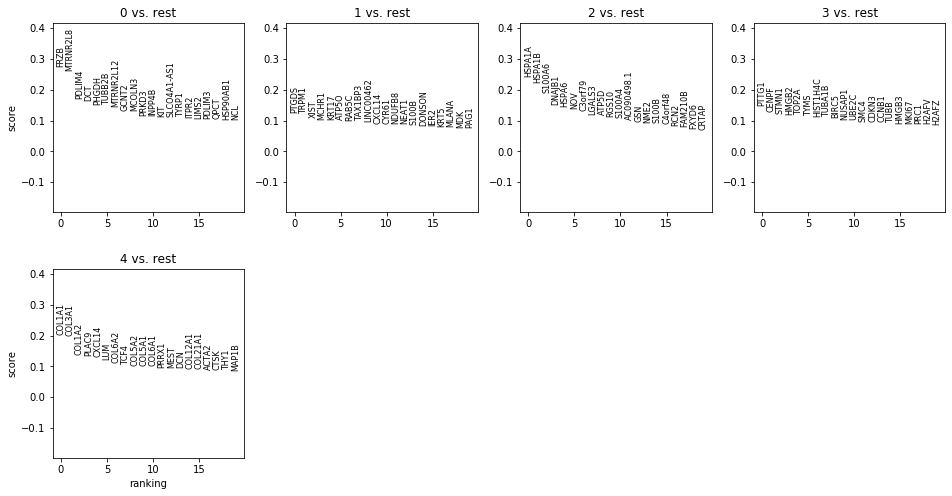

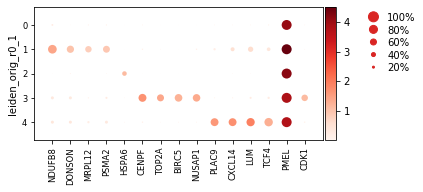

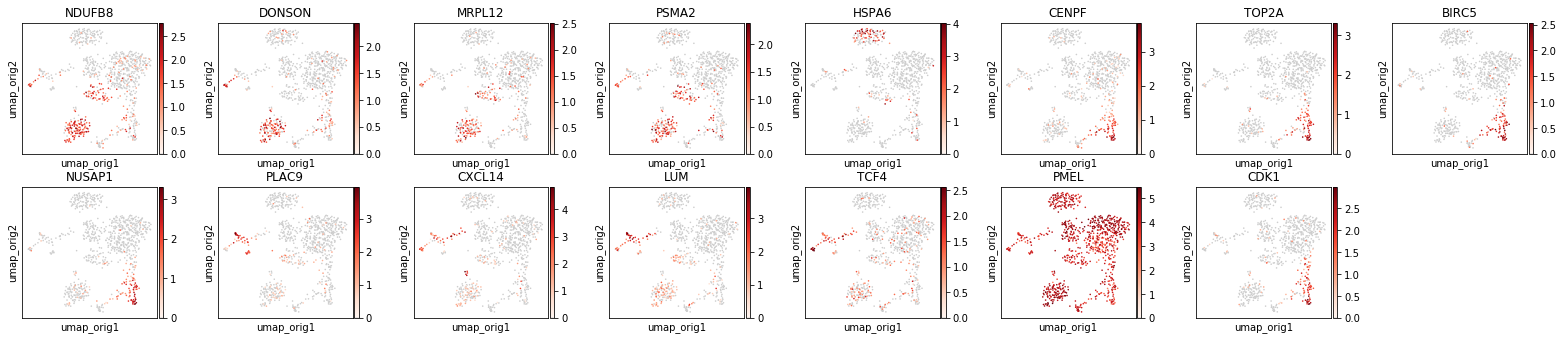

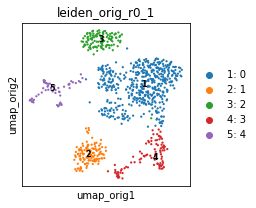

In [60]:
orig_de_genes1 = diffexp(
    ad1, basis='umap', key='orig', res=0.1,
    filter_params={'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 2},
    extra_genes=['PMEL', 'CDK1']
)
orig_de_genes1.groupby('cluster').head(5)

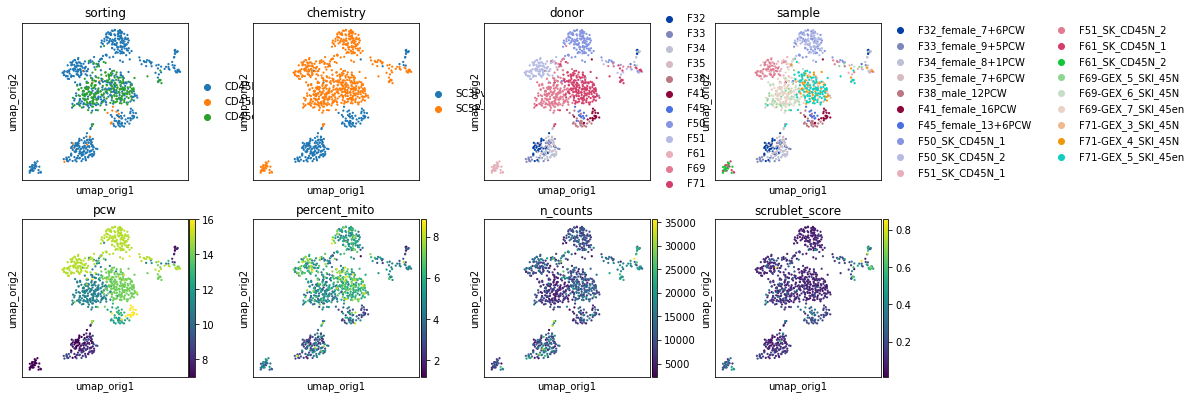

In [54]:
rcParams.update({'figure.figsize':(3,3)})
plot_scatter(ad2, basis='umap_orig',
             color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'], size=20)

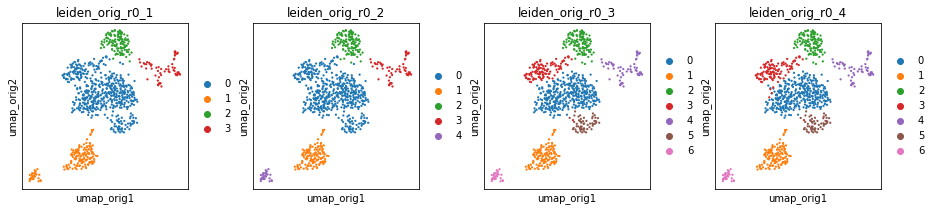

In [55]:
plot_scatter(ad2, basis='umap_orig', color_map=expr_cmap,
             color=[f'leiden_orig_r{str(res).replace(".", "_")}' for res in [0.1, 0.2, 0.3, 0.4]], size=20, ncols=4)

In [56]:
doublet_freq = ad2.obs.groupby('leiden_orig_r0_1')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

                      freq         p
leiden_orig_r0_1                    
0                 0.010989  0.499999
1                 0.000000  0.750000
2                 0.000000  0.750000
3                 0.095238  0.000000


In [57]:
doublet_freq = ad2.obs.groupby('leiden_orig_r0_1')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

                     score             p
leiden_orig_r0_1                        
0                 0.132285  7.238426e-01
1                 0.140593  7.238426e-01
2                 0.088561  8.927497e-01
3                 0.346531  1.025022e-07


cluster   ref  rank   genes    scores
14710       1  rest    19  NDUFB8  0.072250
14715       1  rest    24  DONSON  0.066966
29386       2  rest     4   HSPA6  0.155580
44075       3  rest     2  CXCL14  0.138408
44077       3  rest     4   PLAC9  0.136351
44078       3  rest     5     LUM  0.120832
44079       3  rest     6    TCF4  0.116739
44080       3  rest     7    MEST  0.116383

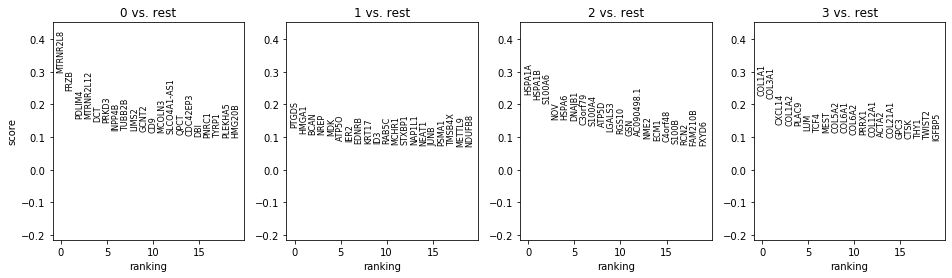

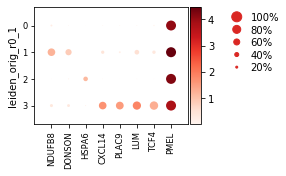

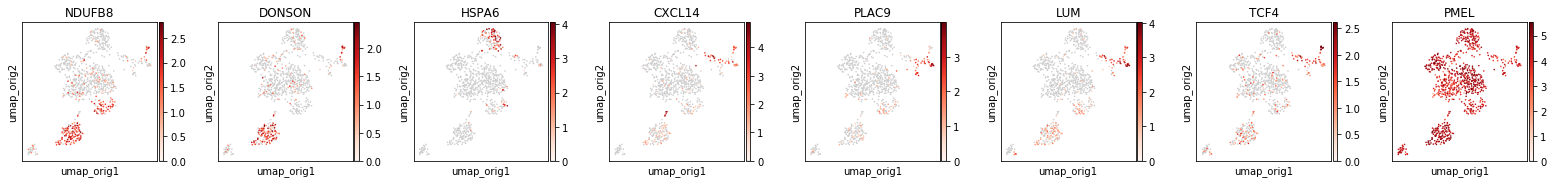

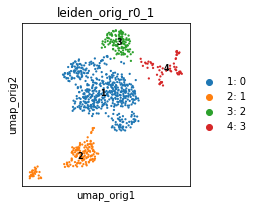

In [59]:
orig_de_genes2 = diffexp(
    ad2, basis='umap', key='orig', res=0.1, method='logreg',
    filter_params={'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 2},
    extra_genes=['PMEL']
)
orig_de_genes2.groupby('cluster').head(5)

# 4.1 Harmony

In [61]:
ss.lib.simple_default_pipeline(
    ad1,
    filter_params=None, norm_params=None, hvg_params=None, scale_params=None, pca_params=None,
#     harmony_params=None,
    harmony_params={'batch': 'sample'},
    nb_params={'use_rep': 'X_pca_hm', 'key_added': 'hm'},
    umap_params={'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    leiden_params={'resolution': [0.1, 0.2, 0.3, 0.4], 'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

AnnData object with n_obs × n_vars = 890 × 15250 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'doublet', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'lr_annot', '__is_in_cluster__', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'leiden', 'sorting_colors', 'chemistry_colors', 'donor_colors', 'sample_colors', 'leiden_orig_r0_1_colors', 'leiden_orig_r0_2_colors', 'leiden_orig_r0_3_colors', 'leiden_orig_r0_4_colors', 'rank_genes_groups_orig_r0_1', 'rank_genes_groups_orig_r0_1_filtered', 'neighbors_hm', 'neighbors'
    obsm: 'X_pca', 'X_umap_orig', 'X_pca_hm', 'X_umap_h

In [62]:
ss.lib.simple_default_pipeline(
    ad2,
    filter_params=None, norm_params=None, hvg_params=None, scale_params=None, pca_params=None,
#     harmony_params=None,
    harmony_params={'batch': 'sample'},
    nb_params={'use_rep': 'X_pca_hm', 'key_added': 'hm'},
    umap_params={'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    leiden_params={'resolution': [0.1, 0.2, 0.3, 0.4], 'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

AnnData object with n_obs × n_vars = 890 × 14691 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'doublet', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'lr_annot', '__is_in_cluster__', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'leiden', 'sorting_colors', 'chemistry_colors', 'donor_colors', 'sample_colors', 'leiden_orig_r0_1_colors', 'leiden_orig_r0_2_colors', 'leiden_orig_r0_3_colors', 'leiden_orig_r0_4_colors', 'rank_genes_groups_orig_r0_1', 'rank_genes_groups_orig_r0_1_filtered', 'neighbors_hm', 'neighbors'
    obsm: 'X_pca', 'X_umap_orig', 'X_pca_hm', 'X_umap_h

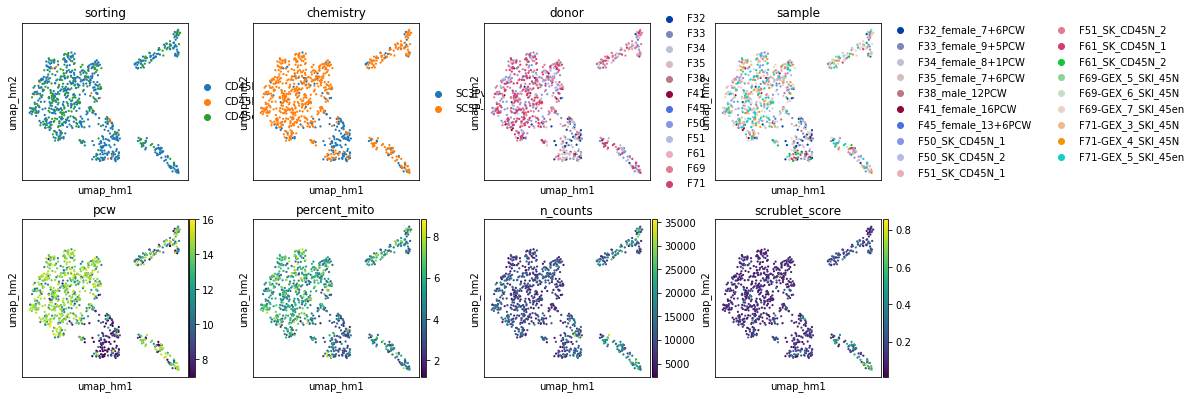

In [71]:
rcParams.update({'figure.figsize':(3,3)})
plot_scatter(ad1, basis='umap_hm',
             color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'], size=20)

In [64]:
ss.lib.leiden(ad1, use_graph='neighbors_hm', key_added='hm', resolution=[0.5, 0.6, 0.7])

AnnData object with n_obs × n_vars = 890 × 15250 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'doublet', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'lr_annot', '__is_in_cluster__', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_hm_r0_6', 'leiden_hm_r0_7'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'leiden', 'sorting_colors', 'chemistry_colors', 'donor_colors', 'sample_colors', 'leiden_orig_r0_1_colors', 'leiden_orig_r0_2_colors', 'leiden_orig_r0_3_colors', 'leiden_orig_r0_4_colors', 'rank_genes_groups_orig_r0_1', 'rank_genes_groups_orig_r0_1_filtered', 'neighbors_hm', 'neighbors'
 

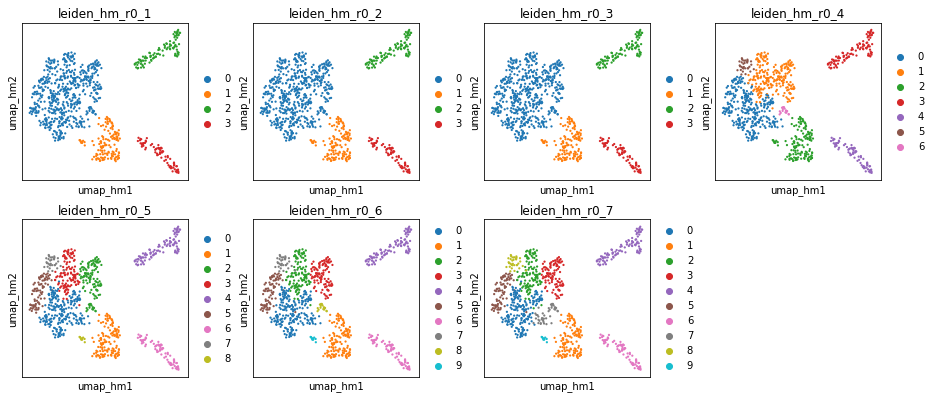

In [67]:
rcParams.update({'figure.figsize':(3,3)})
plot_scatter(ad1, basis='umap_hm', color=[f'leiden_hm_r0_{i}' for i in (1,2,3,4,5,6,7)], size=20)

In [68]:
doublet_freq = ad1.obs.groupby('leiden_hm_r0_1')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

                    freq             p
leiden_hm_r0_1                        
0               0.007030  8.406257e-01
1               0.013889  7.390614e-01
2               0.000000  8.451579e-01
3               0.078947  5.782352e-11


In [69]:
doublet_freq = ad1.obs.groupby('leiden_hm_r0_1')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

                   score         p
leiden_hm_r0_1                    
0               0.111880  0.842728
1               0.144766  0.842728
2               0.178844  0.731412
3               0.327060  0.001743


cluster   ref  rank   genes    scores
30500       2  rest     0    TYMS  0.171352
30504       2  rest     4     TK1  0.129348
30505       2  rest     5   UBE2C  0.123439
30506       2  rest     6  PKMYT1  0.123401
30507       2  rest     7  MAD2L1  0.121592
45751       3  rest     1  CXCL14  0.206806
45753       3  rest     3     DCN  0.132876
45754       3  rest     4    IGF2  0.128095
45755       3  rest     5   PLAC9  0.122710
45756       3  rest     6    MEST  0.116820

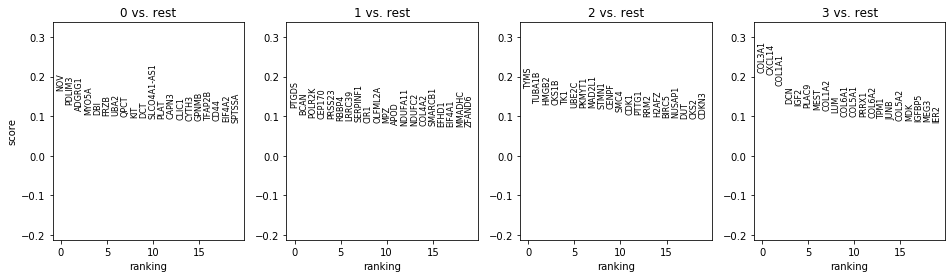

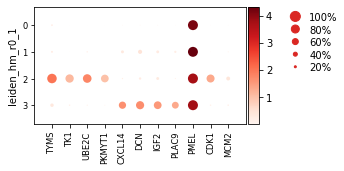

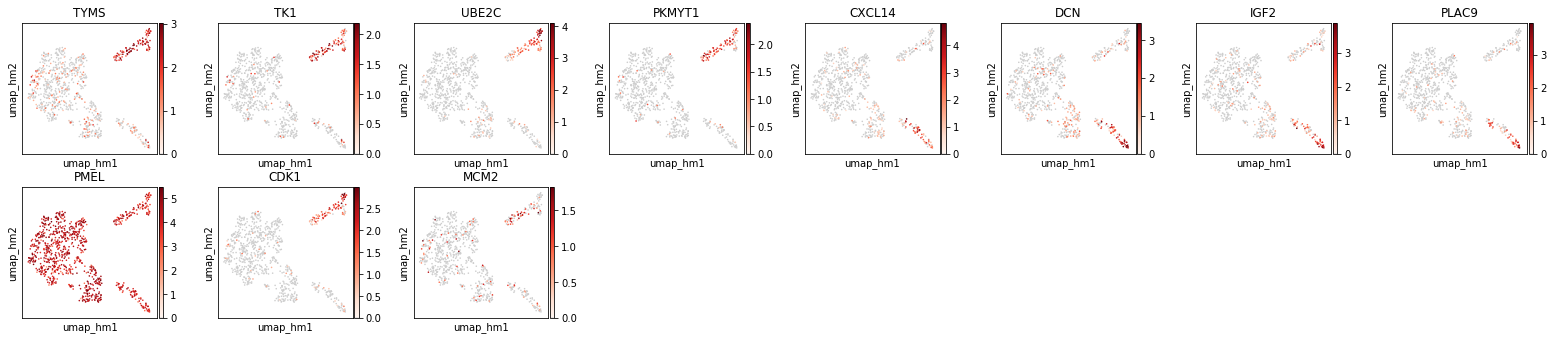

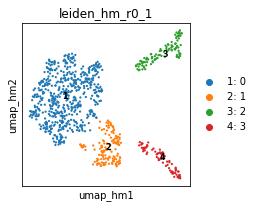

In [72]:
hm_de_genes1 = diffexp(
    ad1, basis='umap', key='hm', res=0.1, method='logreg',
    filter_params={'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 2},
    extra_genes=['PMEL', 'CDK1', 'MCM2']
)
hm_de_genes1.groupby('cluster').head(5)

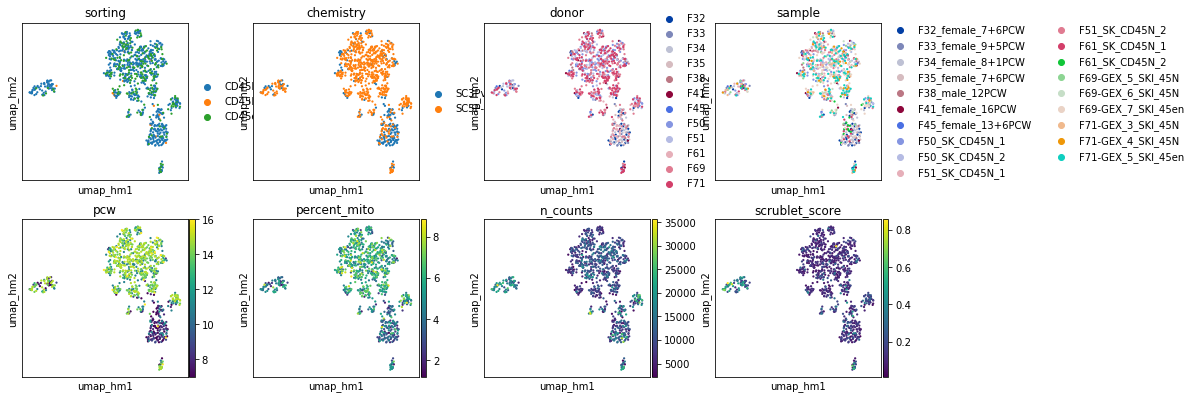

In [73]:
rcParams.update({'figure.figsize':(3,3)})
plot_scatter(ad2, basis='umap_hm',
             color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'], size=20)

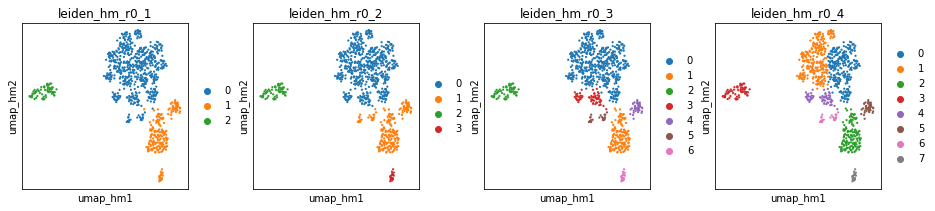

In [75]:
rcParams.update({'figure.figsize':(3,3)})
plot_scatter(ad2, basis='umap_hm', color=[f'leiden_hm_r0_{i}' for i in (1,2,3,4)], size=20)

In [76]:
doublet_freq = ad2.obs.groupby('leiden_hm_r0_2')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

                    freq         p
leiden_hm_r0_2                    
0               0.006745  0.767101
1               0.009390  0.767101
2               0.000000  0.876778
3               0.315789  0.000000


cluster   ref  rank   genes    scores
29384       2  rest     2  CXCL14  0.156346
29385       2  rest     3     LUM  0.149143
29387       2  rest     5    GPC3  0.137711
29388       2  rest     6    TCF4  0.137027
29389       2  rest     7    MEST  0.136946
44073       3  rest     0   ACTA2  0.189390
44074       3  rest     1   TAGLN  0.132967
44076       3  rest     3    MYL9  0.107790
44077       3  rest     4    CCL2  0.093918
44078       3  rest     5  COL4A1  0.084538

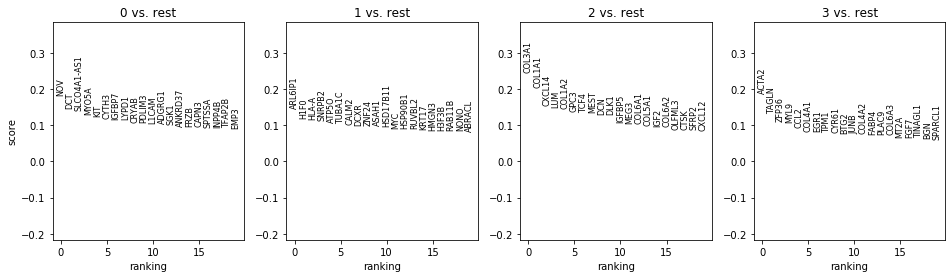

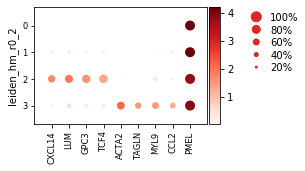

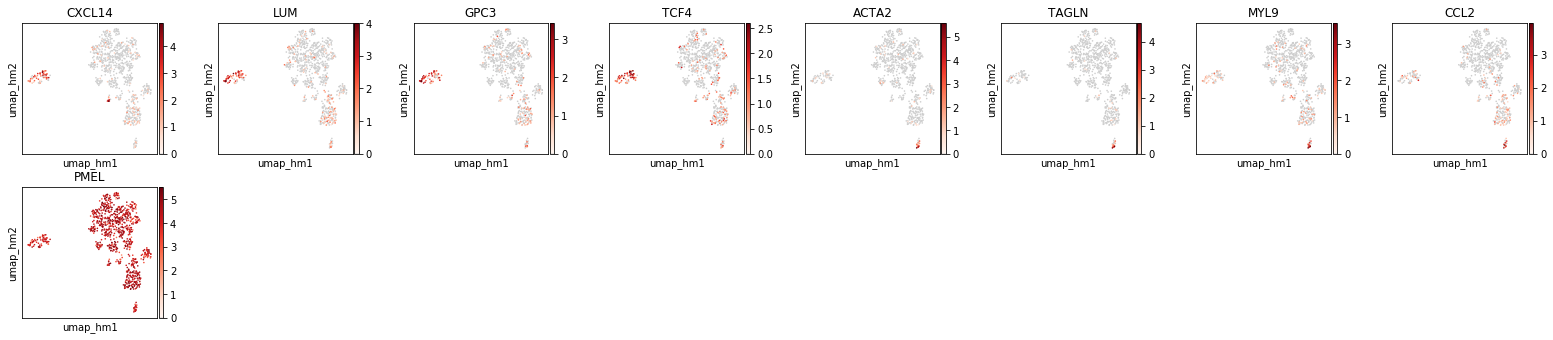

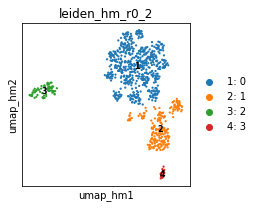

In [77]:
hm_de_genes2 = diffexp(
    ad2, basis='umap', key='hm', res=0.2,
    filter_params={'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 2},
    extra_genes=['PMEL']
)
hm_de_genes2.groupby('cluster').head(5)

# 4.2 BBKNN

In [23]:
ad1.uns['neighbors'] = ad1.uns['neighbors_orig']
bbknn.bbknn(ad1, batch_key='sample', metric='euclidean', neighbors_within_batch=2, copy=False)
ad1.uns['neighbors_bk'] = ad1.uns['neighbors']

In [24]:
ss.lib.umap(ad1, use_graph='neighbors_bk', key_added='bk')

AnnData object with n_obs × n_vars = 890 × 15250 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'doublet', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'lr_annot', '__is_in_cluster__', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_hm_r0_6', 'leiden_hm_r0_7', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'leiden_hm_nocc_r0_1', 'leiden_hm_nocc_r0_2', 'leiden_hm_nocc_r0_3', 'leiden_hm_nocc_r0_4', 'rachel_annot1'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'chemistry_colors', 'donor_colors', 'leiden', 'leiden_bk_r0_1_colors', 'leiden_bk_r0_2_colors', 'leiden_bk_r0_3_col

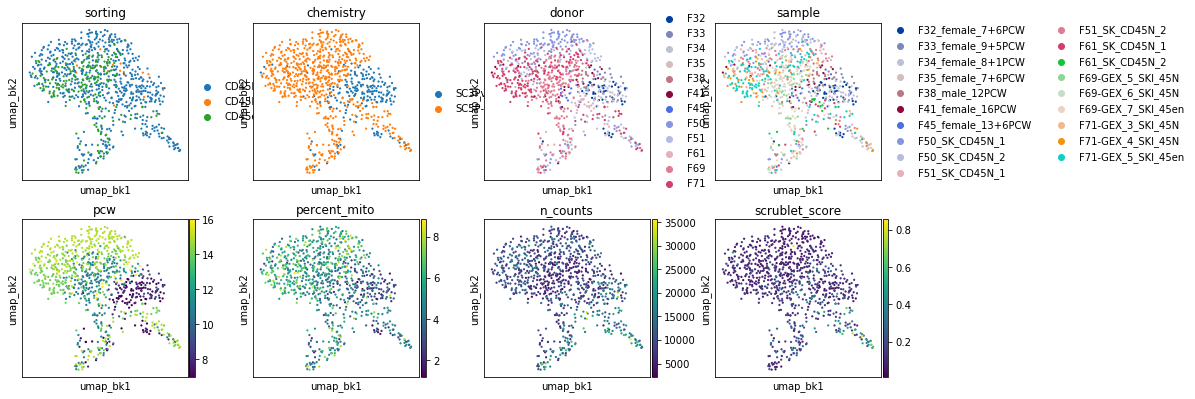

In [25]:
rcParams.update({'figure.figsize':(3,3)})
plot_scatter(ad1, basis='umap_bk',
             color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'],
             size=20)

In [26]:
ss.lib.leiden(ad1, use_graph='neighbors_bk', key_added='bk', resolution=[0.1, 0.2, 0.3, 0.4, 0.5,])

['leiden_bk_r0_1',
 'leiden_bk_r0_2',
 'leiden_bk_r0_3',
 'leiden_bk_r0_4',
 'leiden_bk_r0_5']

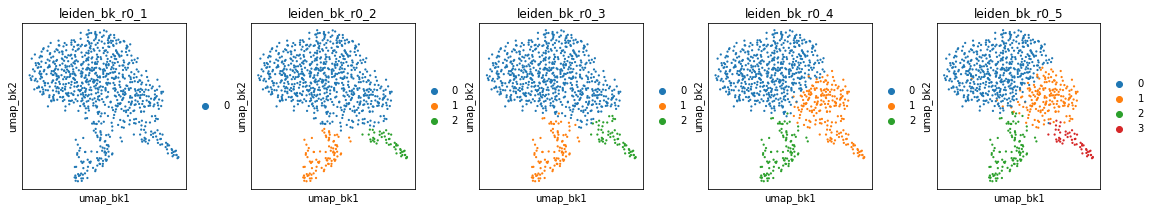

In [27]:
rcParams.update({'figure.figsize':(3,3)})
plot_scatter(ad1, basis='umap_bk', color=[f'leiden_bk_r{str(res).replace(".", "_")}' for res in (0.1, 0.2, 0.3, 0.4, 0.5,)], size=20, ncols=5)

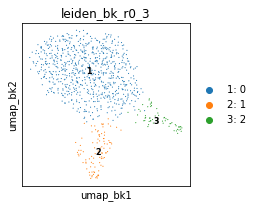

In [22]:
rcParams.update({'figure.figsize':(3,3)})
ss.lib.plot_embedding(ad1, basis='umap_bk', groupby='leiden_bk_r0_3', size=5)

In [85]:
doublet_freq = ad1.obs.groupby('leiden_bk_r0_3')['doublet'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=True)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

                    freq         p
leiden_bk_r0_3                    
0               0.010909  0.442540
1               0.000000  0.500000
2               0.000000  0.500000
3               0.090909  0.114208
4               0.000000  0.500000


In [86]:
doublet_freq = ad1.obs.groupby('leiden_bk_r0_3')['scrublet_score'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

                   score         p
leiden_bk_r0_3                    
0               0.111819  0.743101
1               0.143938  0.500000
2               0.177117  0.250000
3               0.349852  0.000014
4               0.072326  0.927270


cluster   ref  rank    genes    scores
15264       1  rest    14   NDUFB8  0.075479
30503       2  rest     3     TYMS  0.125249
30505       2  rest     5    UBE2C  0.113021
30507       2  rest     7    CENPF  0.111025
30509       2  rest     9     PRC1  0.109368
30510       2  rest    10   MAD2L1  0.102772
45753       3  rest     3      LUM  0.125841
45754       3  rest     4   CXCL14  0.122472
45755       3  rest     5    PLAC9  0.114060
45756       3  rest     6      DCN  0.107520
45757       3  rest     7    PRRX1  0.105546
61000       4  rest     0    HSPA6  0.055503
61009       4  rest     9     CAPG  0.028206
61010       4  rest    10  ATG16L1  0.027628
61032       4  rest    32    SGSM3  0.022190
61044       4  rest    44    PRKG2  0.020959

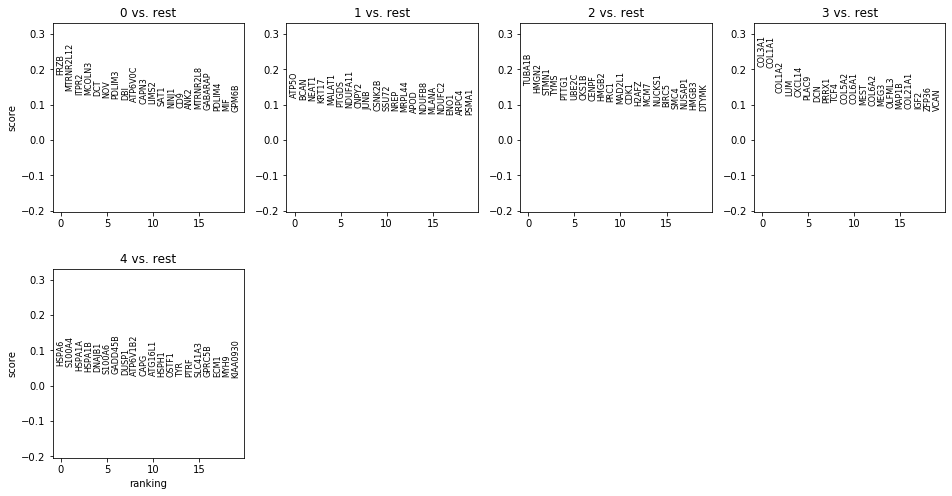

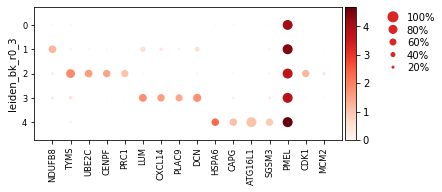

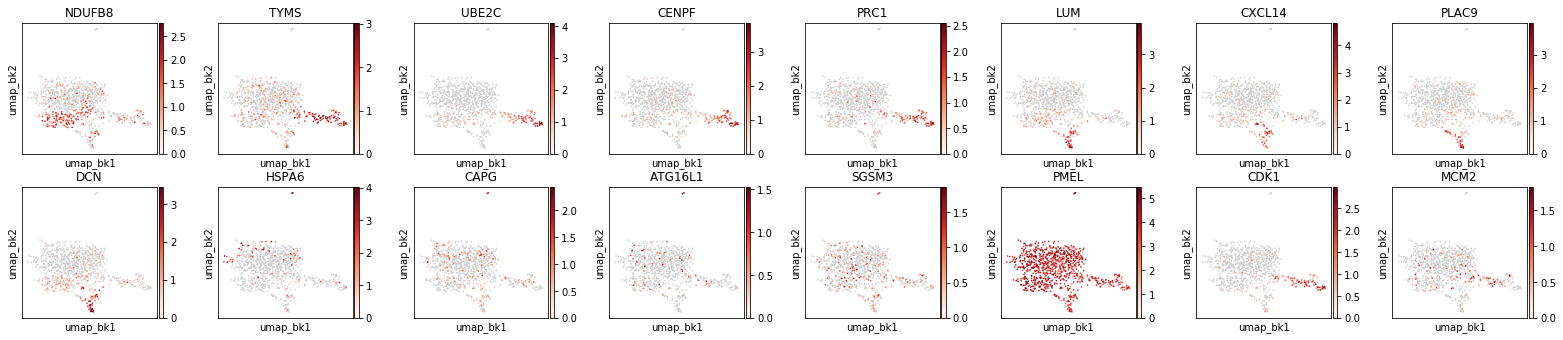

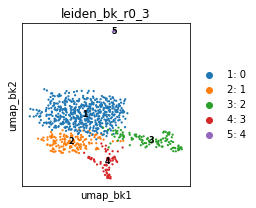

In [87]:
bk_de_genes1 = diffexp(
    ad1, basis='umap', key='bk', res=0.3,
    filter_params={'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 2},
    extra_genes=['PMEL', 'CDK1', 'MCM2']
)
bk_de_genes1.groupby('cluster').head(5)

In [28]:
ad2.uns['neighbors'] = ad2.uns['neighbors_orig']
bbknn.bbknn(ad2, batch_key='sample', metric='euclidean', neighbors_within_batch=2, copy=False)
ad2.uns['neighbors_bk'] = ad2.uns['neighbors']

In [29]:
ss.lib.umap(ad2, use_graph='neighbors_bk', key_added='bk')

AnnData object with n_obs × n_vars = 890 × 14691 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'doublet', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'lr_annot', '__is_in_cluster__', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'chemistry_colors', 'donor_colors', 'leiden', 'leiden_bk_r0_1_colors', 'leiden_bk_r0_2_colors', 'leiden_bk_r0_3_colors', 'leiden_bk_r0_4_colors', 'leiden_bk_r0_5_colors', 'leiden_hm_r0_1_colors', 'leiden_hm_r0_2_colors', 'leiden_hm_r0_3_colors', 'leiden_hm_r0_4_colors', 'leiden

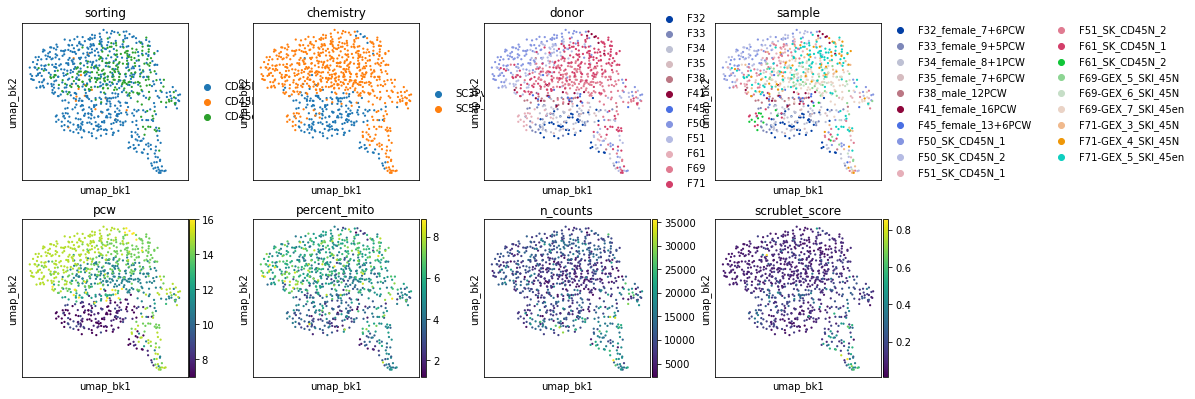

In [30]:
rcParams.update({'figure.figsize':(3,3)})
plot_scatter(ad2, basis='umap_bk',
             color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'],
             size=20)

In [31]:
ss.lib.leiden(ad2, use_graph='neighbors_bk', key_added='bk', resolution=[0.1, 0.2, 0.3, 0.4, 0.5,])

['leiden_bk_r0_1',
 'leiden_bk_r0_2',
 'leiden_bk_r0_3',
 'leiden_bk_r0_4',
 'leiden_bk_r0_5']

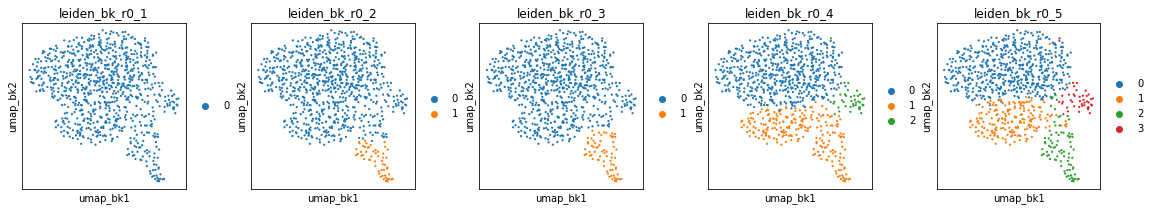

In [32]:
rcParams.update({'figure.figsize':(3,3)})
plot_scatter(
    ad2, basis='umap_bk',
    color=[f'leiden_bk_r{str(res).replace(".", "_")}' for res in (0.1, 0.2, 0.3, 0.4, 0.5,)], size=20, ncols=5)

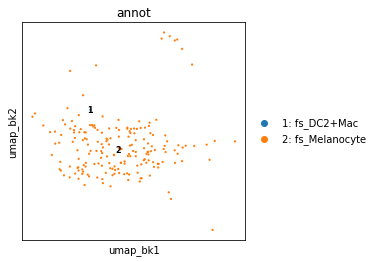

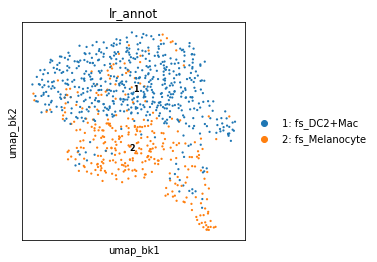

In [33]:
rcParams.update({'figure.figsize':(4,4)})
k_annot = (ad2.obs['annot'] != 'nan').values
ss.lib.plot_embedding(ad2[k_annot, :], basis='umap_bk', groupby='annot', size=20)
ss.lib.plot_embedding(ad2, basis='umap_bk', groupby='lr_annot', size=20)

In [97]:
doublet_freq = ad2.obs.groupby('leiden_bk_r0_2')['doublet'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

                    freq     p
leiden_bk_r0_2                
0               0.009646  0.25
1               0.000000  0.75
2               0.081081  0.00
3               0.000000  0.75


In [98]:
doublet_freq = ad2.obs.groupby('leiden_bk_r0_2')['scrublet_score'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

                   score         p
leiden_bk_r0_2                    
0               0.119685  0.778226
1               0.129888  0.719975
2               0.339538  0.000720
3               0.194713  0.280025


cluster   ref  rank    genes    scores
14695       1  rest     4   NDUFB8  0.096393
14715       1  rest    24   DONSON  0.073461
14745       1  rest    54    PSMA2  0.056438
29382       2  rest     0   CXCL14  0.235420
29385       2  rest     3      DCN  0.131887
29386       2  rest     4     MEST  0.126109
29388       2  rest     6      LUM  0.114008
29390       2  rest     8     TCF4  0.113087
44086       3  rest    13  TMSB15A  0.065209

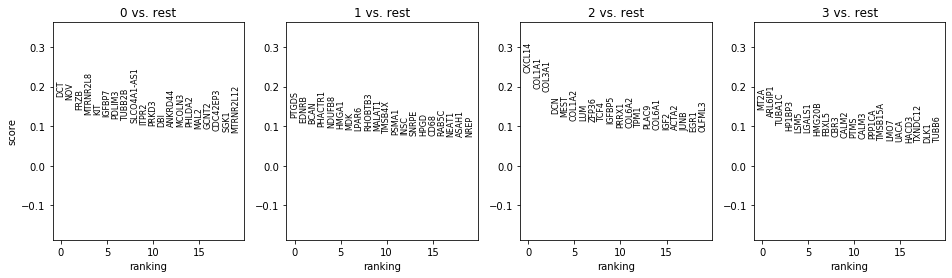

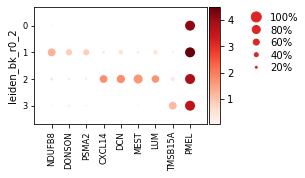

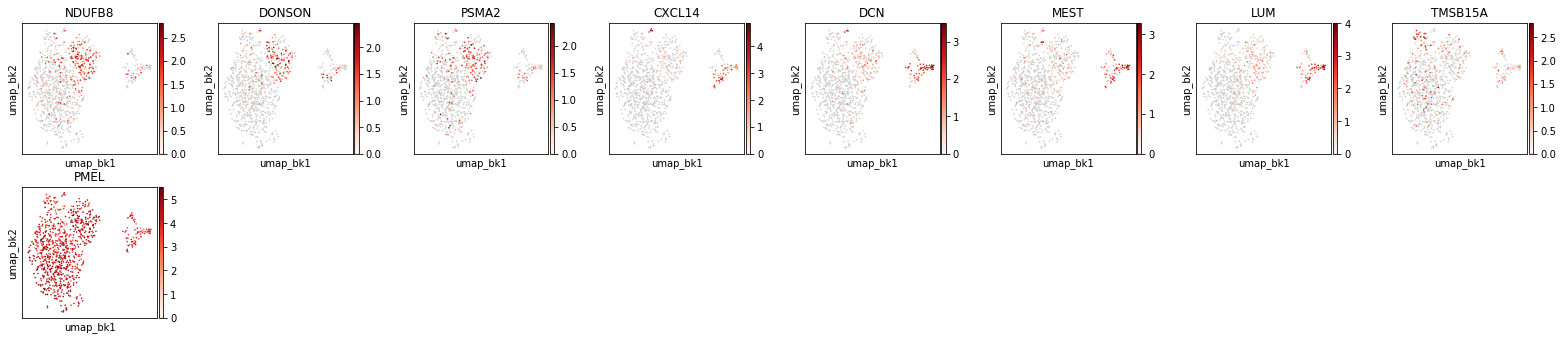

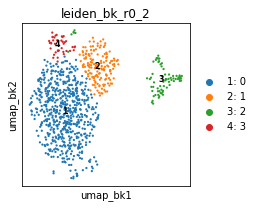

In [99]:
bk_de_genes2 = diffexp(
    ad2, basis='umap', key='bk', res=0.2, method='logreg',
    filter_params={'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 2},
    extra_genes=['PMEL']
)
bk_de_genes2.groupby('cluster').head(5)

# 5. Compare clustering

In [100]:
adt = ad1.copy()
adt.obs['leiden_orig_nocc_r0_1'] = ad2.obs['leiden_orig_r0_1']
adt.obs['leiden_hm_nocc_r0_2'] = ad2.obs['leiden_hm_r0_2']
adt.obs['leiden_bk_nocc_r0_2'] = ad2.obs['leiden_bk_r0_2']

In [105]:
adt.obsm['X_umap_nocc_orig'] = ad2.obsm['X_umap_orig']
adt.obsm['X_umap_nocc_hm'] = ad2.obsm['X_umap_hm']
adt.obsm['X_umap_nocc_bk'] = ad2.obsm['X_umap_bk']

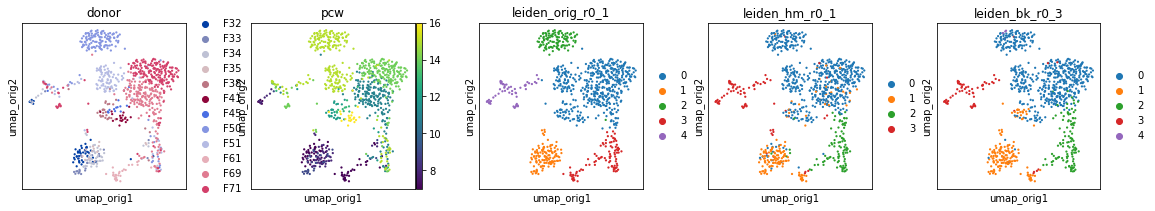

In [101]:
plot_scatter(
    adt, basis='umap_orig',
    color=['donor', 'pcw', 'leiden_orig_r0_1', 'leiden_hm_r0_1', 'leiden_bk_r0_3'], ncols=5, size=20)

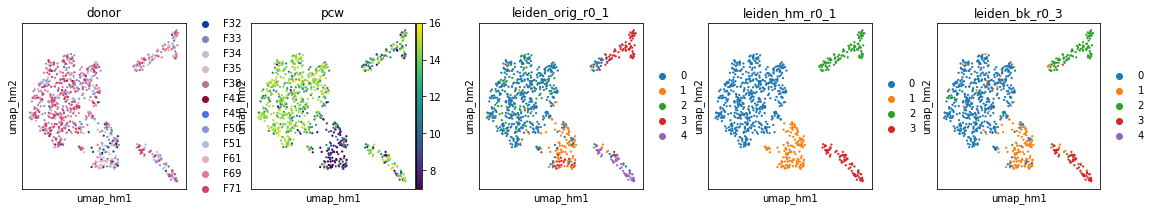

In [102]:
plot_scatter(
    adt, basis='umap_hm',
    color=['donor', 'pcw', 'leiden_orig_r0_1', 'leiden_hm_r0_1', 'leiden_bk_r0_3'], ncols=5, size=20)

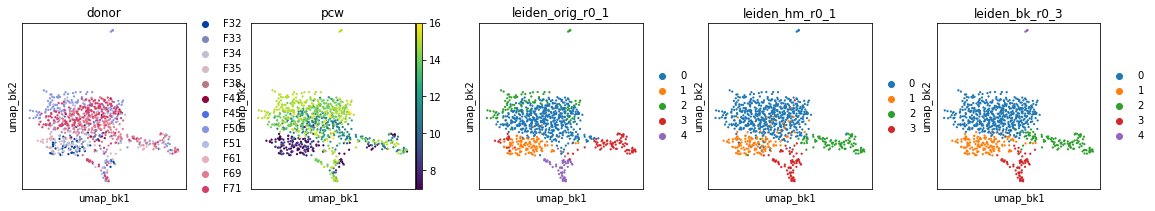

In [103]:
plot_scatter(
    adt, basis='umap_bk',
    color=['donor', 'pcw', 'leiden_orig_r0_1', 'leiden_hm_r0_1', 'leiden_bk_r0_3'], ncols=5, size=20)

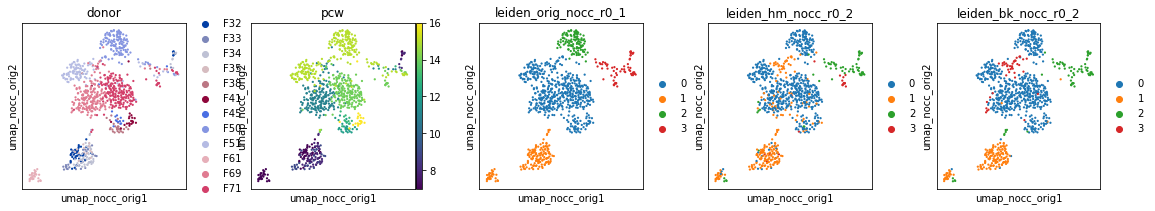

In [106]:
plot_scatter(
    adt, basis='umap_nocc_orig',
    color=['donor', 'pcw', 'leiden_orig_nocc_r0_1', 'leiden_hm_nocc_r0_2', 'leiden_bk_nocc_r0_2'], ncols=5, size=20)

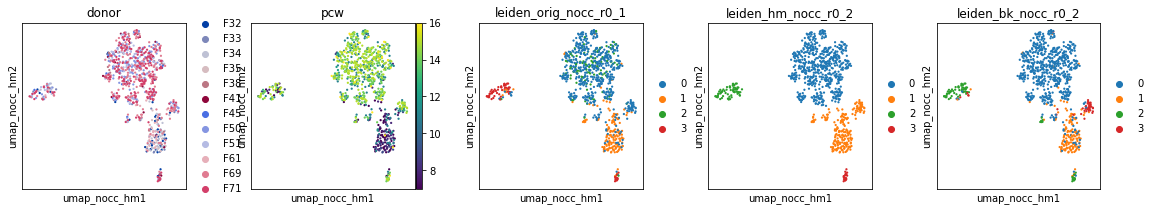

In [107]:
plot_scatter(
    adt, basis='umap_nocc_hm',
    color=['donor', 'pcw', 'leiden_orig_nocc_r0_1', 'leiden_hm_nocc_r0_2', 'leiden_bk_nocc_r0_2'], ncols=5, size=20)

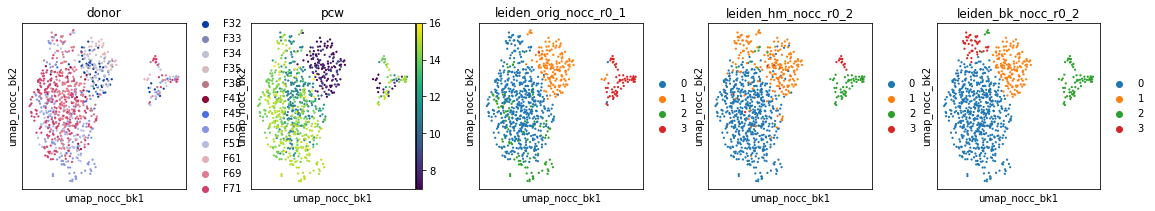

In [108]:
plot_scatter(
    adt, basis='umap_nocc_bk',
    color=['donor', 'pcw', 'leiden_orig_nocc_r0_1', 'leiden_hm_nocc_r0_2', 'leiden_bk_nocc_r0_2'], ncols=5, size=20)

In [109]:
ss.lib.cross_table(adt, 'leiden_orig_nocc_r0_1', 'leiden_orig_r0_1', highlight=True)

In [110]:
ss.lib.cross_table(adt, 'leiden_hm_nocc_r0_2', 'leiden_hm_r0_1', highlight=True)

In [111]:
ss.lib.cross_table(adt, 'leiden_bk_nocc_r0_2', 'leiden_bk_r0_3', highlight=True)

In [112]:
ss.lib.cross_table(adt, 'leiden_bk_r0_3', 'leiden_orig_r0_1', highlight=True)

In [113]:
ss.lib.cross_table(adt, 'leiden_bk_r0_3', 'leiden_hm_r0_1', highlight=True)

In [114]:
ss.lib.cross_table(adt, 'leiden_bk_nocc_r0_2', 'leiden_hm_nocc_r0_2', highlight=True)

In [198]:
ss.lib.cross_table(adt, 'leiden_bk_nocc_r0_3', 'leiden_orig_nocc_r0_3', highlight=True)

In [121]:
ad1.write('data/h5ad/fetal_skin_hierarch1_melanocytes_processed.h5ad', compression='gzip')
ad2.write('data/h5ad/fetal_skin_hierarch1_melanocytes_processed_nocc.h5ad', compression='gzip')

In [ ]:
ad1 = sc.read('data/h5ad/fetal_skin_hierarch1_melanocytes_processed.h5ad')
ad2 = sc.read('data/h5ad/fetal_skin_hierarch1_melanocytes_processed_nocc.h5ad')

In [117]:
ad1.obsm['X_umap_hm_nocc'] = ad2.obsm['X_umap_hm']
for r in (1,2,3,4):
    ad1.obs[f'leiden_hm_nocc_r0_{r}'] = ad2.obs[f'leiden_hm_r0_{r}']

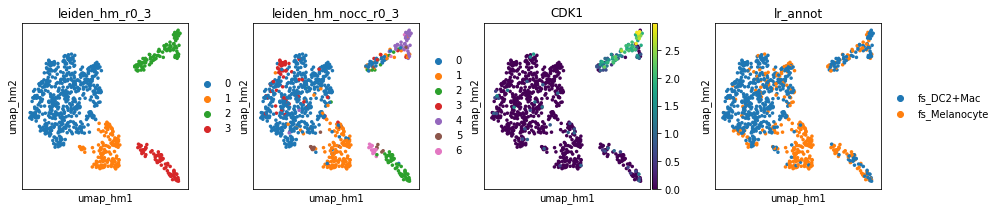

In [118]:
ss.lib.set_figsize((3,3))
plot_scatter(ad1, basis='umap_hm', color=['leiden_hm_r0_3', 'leiden_hm_nocc_r0_3', 'CDK1', 'lr_annot'], size=20)

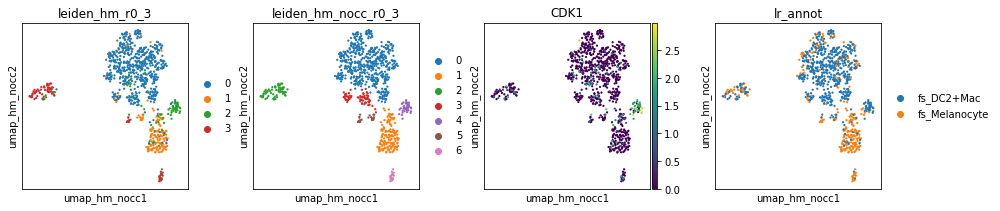

In [120]:
ss.lib.set_figsize((3,3))
plot_scatter(ad1, basis='umap_hm_nocc', color=['leiden_hm_r0_3', 'leiden_hm_nocc_r0_3', 'CDK1', 'lr_annot'], size=20)

# 6. Incorporate annotation

In [34]:
ad1 = sc.read(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed.h5ad')
ad2 = sc.read(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed_nocc.h5ad')
ad1.uns['neighbors_hm_nocc'] = ad2.uns['neighbors_hm']
ad1.uns['neighbors_bk_nocc'] = ad2.uns['neighbors_bk']

In [78]:
ad1.obsm['X_umap_hm_nocc'] = ad2.obsm['X_umap_hm']
ad1.obsm['X_umap_bk_nocc'] = ad2.obsm['X_umap_bk']
for res in CLUSTER_RESOLUTIONS:
    r = str(res).replace(".", "_")
    ad1.obs[f'leiden_hm_nocc_r{r}'] = ad2.obs[f'leiden_hm_r{r}']
    ad1.obs[f'leiden_bk_nocc_r{r}'] = ad2.obs[f'leiden_bk_r{r}']

In [37]:
ad1.obs['rachel_annot1'] = ad1.obs['leiden_hm_r0_1'].cat.rename_categories({
    '0': 'Melanocytes',
    '1': 'Melanoblasts',
    '2': 'Proliferating Mel',
    '3': 'Doublets',
})

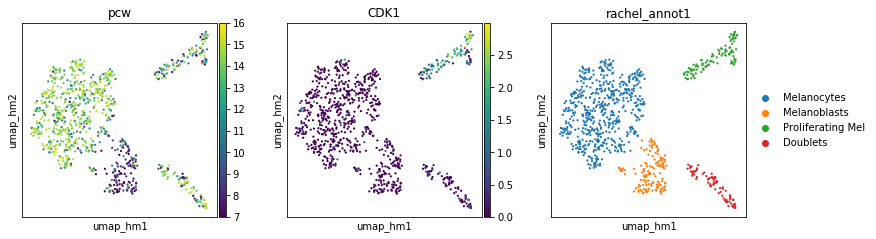

In [38]:
ss.lib.set_figsize((3.5, 3.5))
plot_scatter(ad1, basis='umap_hm', color=['pcw', 'CDK1', 'rachel_annot1'], size=20)

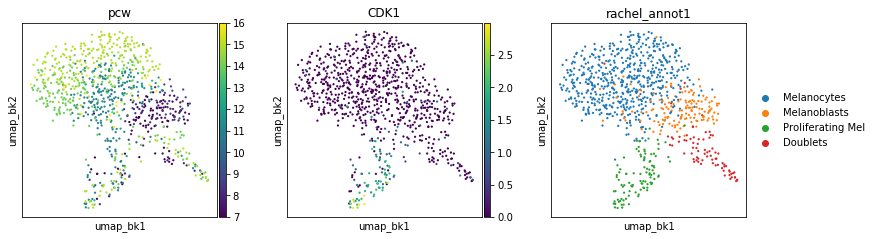

In [39]:
plot_scatter(ad1, basis='umap_bk', color=['pcw', 'CDK1', 'rachel_annot1'], size=20)

In [40]:
ss.lib.cross_table(ad1, 'annot', 'rachel_annot1', highlight=True)

# 7. Over-cluster to remove doublet

In [41]:
ad1

AnnData object with n_obs × n_vars = 890 × 15250 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'doublet', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'lr_annot', '__is_in_cluster__', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', 'leiden_hm_r0_6', 'leiden_hm_r0_7', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5', 'leiden_hm_nocc_r0_1', 'leiden_hm_nocc_r0_2', 'leiden_hm_nocc_r0_3', 'leiden_hm_nocc_r0_4', 'rachel_annot1'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'chemistry_colors', 'donor_colors', 'leiden', 'leiden_bk_r0_1_colors', 'leiden_bk_r0_2_colors', 'leiden_bk_r0_3_col

In [42]:
ss.lib.leiden(ad1, use_graph='neighbors_hm', resolution=[3.0], key_added='hm')

['leiden_hm_r3_0']

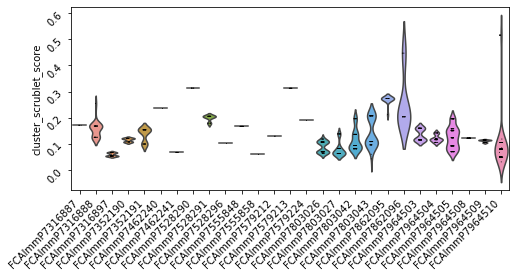

In [43]:
ss.lib.set_figsize((7, 3.5))
sc.pl.violin(ad1, keys='cluster_scrublet_score', groupby='sanger_id', rotation=45)

In [44]:
ad1.obs['scrublet_z'] = ad1.obs.groupby('sanger_id')['scrublet_score'].apply(lambda x: ss.lib.test_outlier(x, robust=True, upper_mad_only=True)[0])
ad1.obs['cluster_scrublet_z'] = ad1.obs.groupby('sanger_id')['cluster_scrublet_score'].apply(lambda x: ss.lib.test_outlier(x, robust=True, upper_mad_only=True)[0])

In [45]:
ad1.obs['cluster_scrublet_z'].describe()

count    890.000000
mean       0.176028
std        1.083813
min       -1.255540
25%        0.000000
50%        0.000000
75%        0.532451
max       11.377179
Name: cluster_scrublet_z, dtype: float64

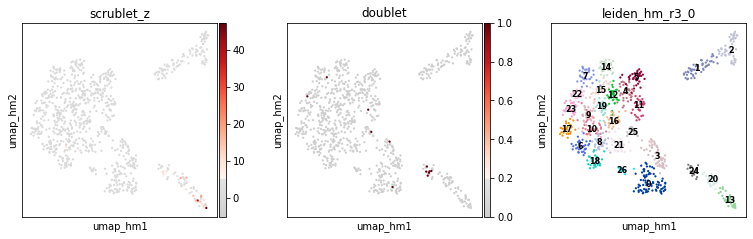

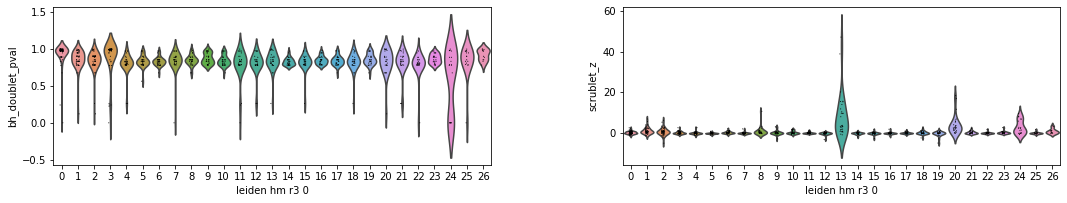

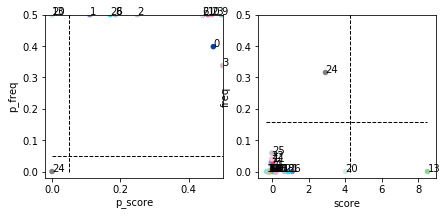

In [49]:
df = check_doublets(ad1, 'leiden_hm_r3_0', basis='umap_hm', p='bh_doublet_pval', score='scrublet_z', initial_pmin=0.05, size=20)

In [50]:
ad1.obs['pooled_doublet'] = ad1.obs['leiden_hm_r3_0'].isin(['13', '20', '24'])

In [51]:
ad1.write(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed.h5ad', compression='lzf')

# 8. Trajectory

In [112]:
ad1n = ad1[~ad1.obs['pooled_doublet'] & (~ad1.obs.leiden_hm_nocc_r0_3.isin(['2','6'])), :]

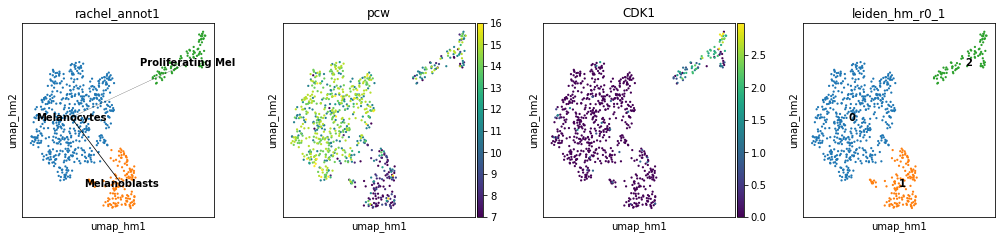

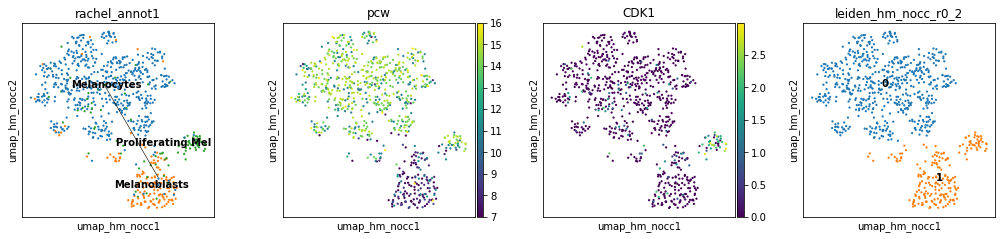

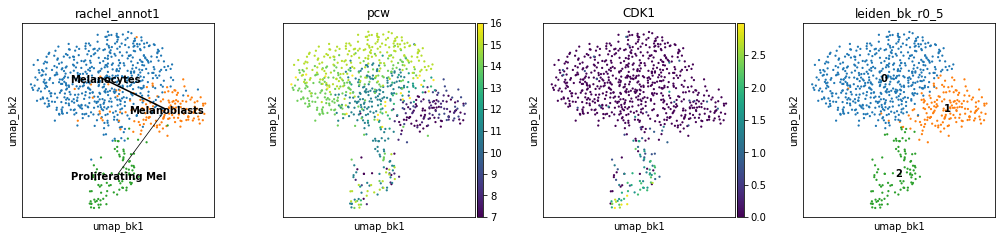

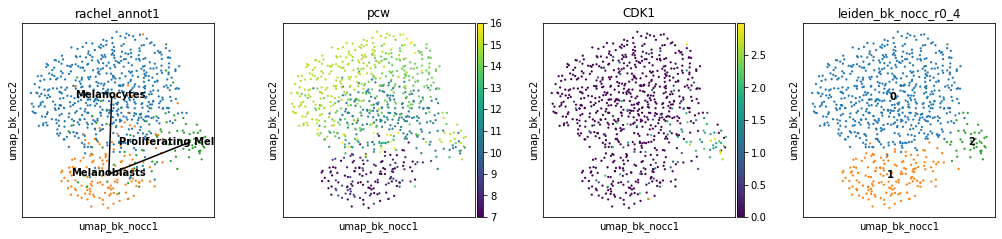

In [114]:
ss.lib.set_figsize((3.5, 3.5))

ss.lib.paga(ad1n, use_graph='neighbors_hm', key_added='hm', groups='leiden_hm_r0_1')
ss.lib.plot_paga(ad1n, basis='umap_hm', use_key='paga_hm', layout='fa', color=['rachel_annot1', 'pcw', 'CDK1', 'leiden_hm_r0_1'],
                 edge_width_scale=1, solid_edges='connectivities_tree', size=20)

ss.lib.paga(ad1n, use_graph='neighbors_hm_nocc', key_added='hm_nocc', groups='leiden_hm_nocc_r0_2')
ss.lib.plot_paga(ad1n, basis='umap_hm_nocc', use_key='paga_hm_nocc', layout='fa', color=['rachel_annot1', 'pcw', 'CDK1', 'leiden_hm_nocc_r0_2'],
                 edge_width_scale=1, solid_edges='connectivities_tree', size=20)

ss.lib.paga(ad1n, use_graph='neighbors_bk', key_added='bk', groups='leiden_bk_r0_5')
ss.lib.plot_paga(ad1n, basis='umap_bk', use_key='paga_bk', layout='fa', color=['rachel_annot1', 'pcw', 'CDK1', 'leiden_bk_r0_5'],
                 edge_width_scale=0.2, solid_edges='connectivities_tree', size=20)

ss.lib.paga(ad1n, use_graph='neighbors_bk_nocc', key_added='bk_nocc', groups='leiden_bk_nocc_r0_4')
ss.lib.plot_paga(ad1n, basis='umap_bk_nocc', use_key='paga_bk_nocc', layout='fa', color=['rachel_annot1', 'pcw', 'CDK1', 'leiden_bk_nocc_r0_4'],
                 root=4, edge_width_scale=0.2, solid_edges='connectivities_tree', size=20)

In [93]:
ad1n.write(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed_nodoublet_paga.h5ad', compression='lzf')